Linear regression to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate

np.random.seed(0)

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings()

Train: 2010-01-09 - 2012-12-31, Test: 2013-01-01 - 2013-01-31
  Median NSE: 0.271514744186221
Train: 2010-01-09 - 2013-01-31, Test: 2013-02-01 - 2013-02-28
  Median NSE: 0.13709972017753913
Train: 2010-01-09 - 2013-02-28, Test: 2013-03-01 - 2013-03-31
  Median NSE: -0.17192670931490195
Train: 2010-01-09 - 2013-03-31, Test: 2013-04-01 - 2013-04-30
  Median NSE: 0.1754874581463738
Train: 2010-01-09 - 2013-04-30, Test: 2013-05-01 - 2013-05-31
  Median NSE: -2.8214987354690777
Train: 2010-01-09 - 2013-05-31, Test: 2013-06-01 - 2013-06-30
  Median NSE: -0.16613032179895681
Train: 2010-01-09 - 2013-06-30, Test: 2013-07-01 - 2013-07-31
  Median NSE: -0.06690408385750302
Train: 2010-01-09 - 2013-07-31, Test: 2013-08-01 - 2013-08-31
  Median NSE: -1.8547677570564984
Train: 2010-01-09 - 2013-08-31, Test: 2013-09-01 - 2013-09-30
  Median NSE: -1.3139385360287756
Train: 2010-01-09 - 2013-09-30, Test: 2013-10-01 - 2013-10-31
  Median NSE: -0.5400868452986001
Train: 2010-01-09 - 2013-10-31, Test: 20

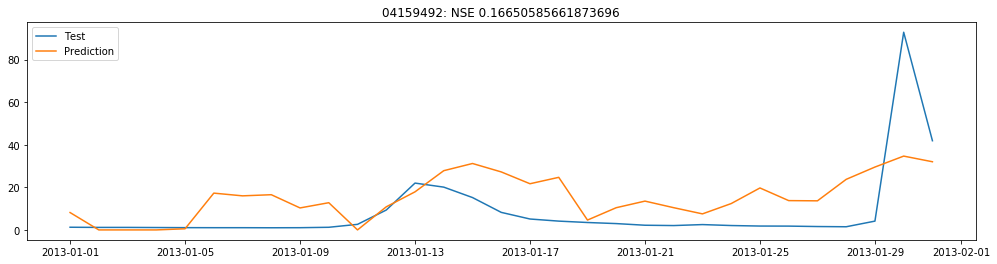

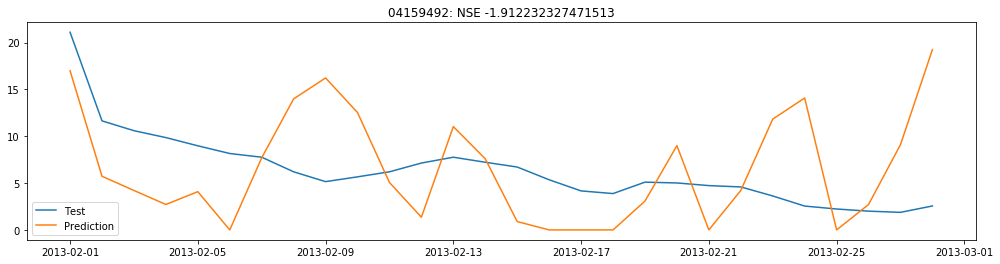

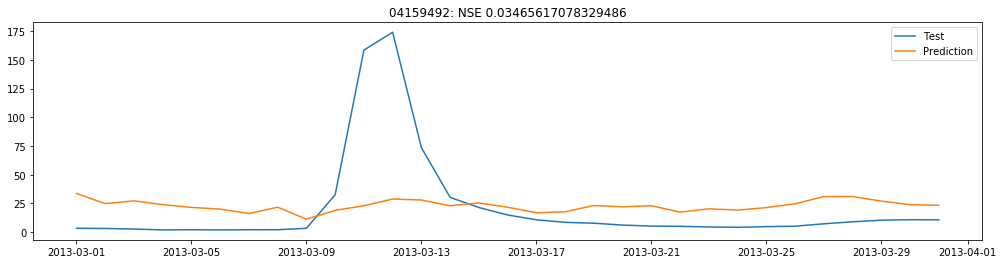

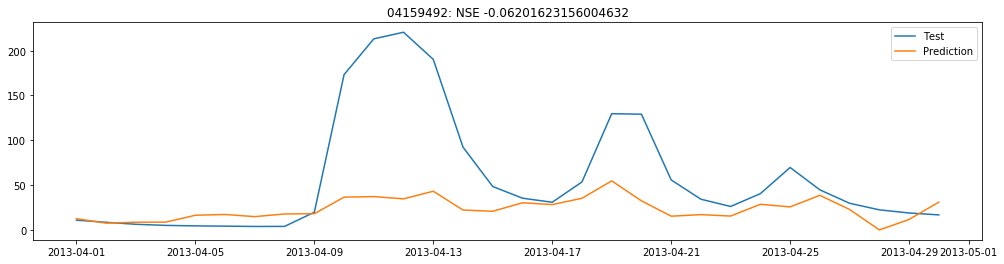

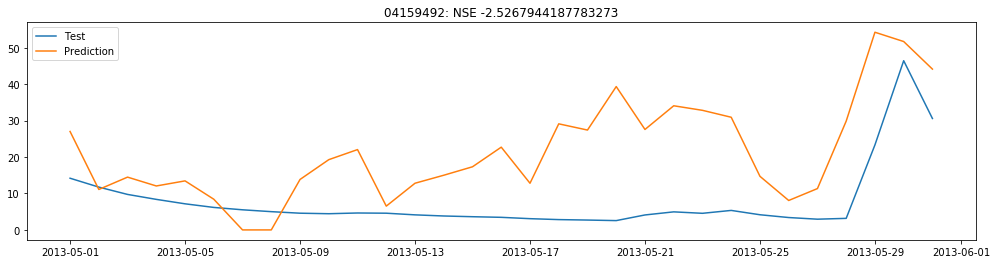

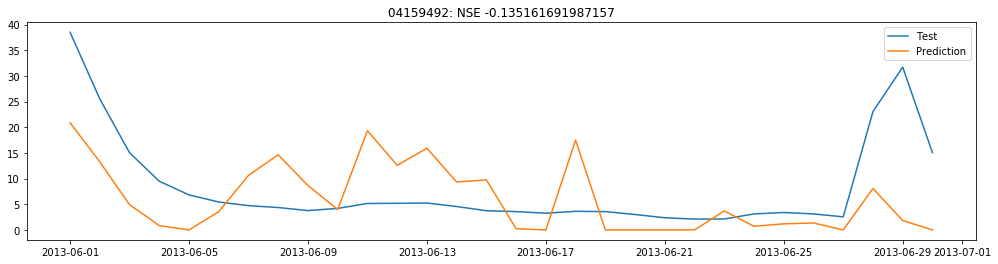

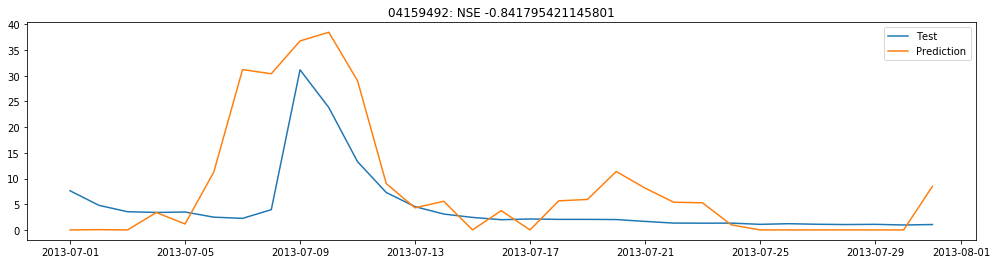

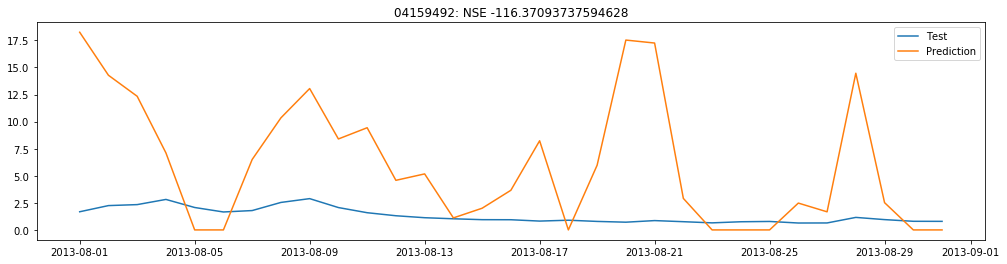

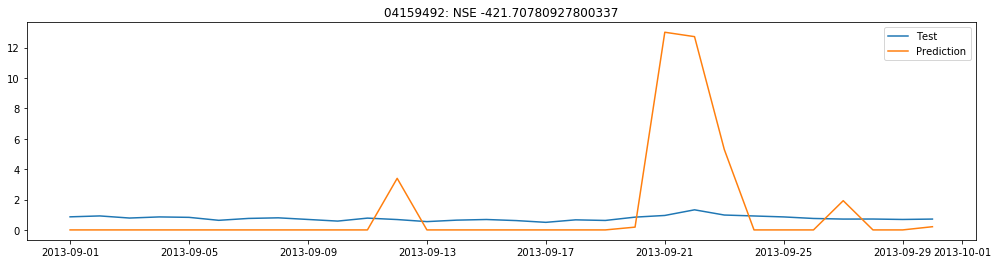

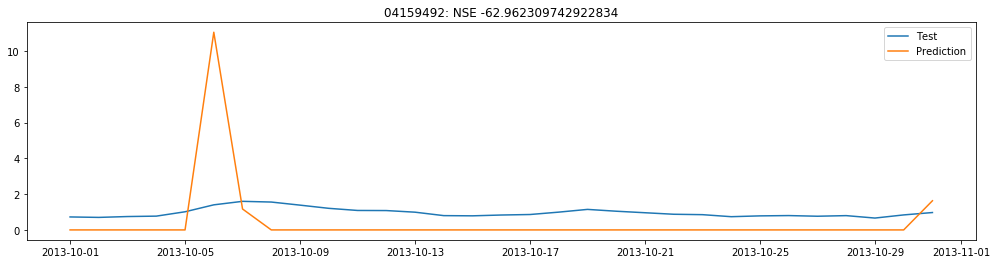

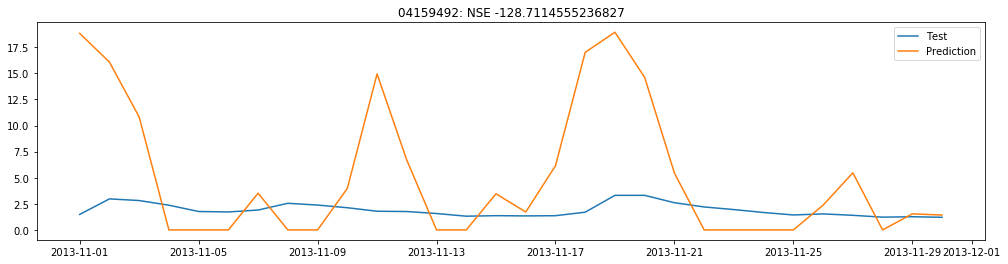

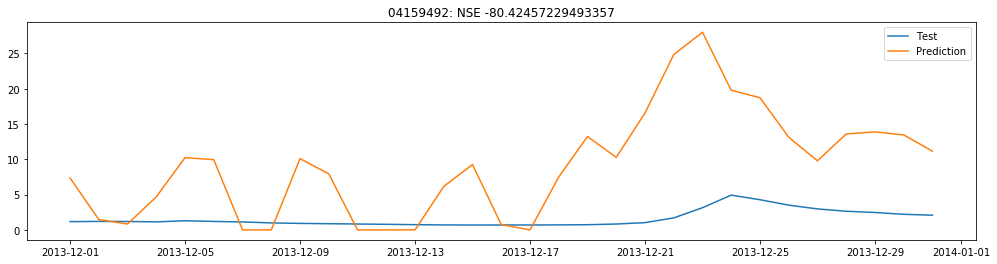

In [13]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_ends = ['2012-12-31', '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31', \
              '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30']
test_ends = train_ends[1:] + ['2013-12-31']

plot_list = ['04159492']
median_nse_list = []
for cv_iter in range(len(train_ends)):
    train_end = train_ends[cv_iter]
    test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
    test_end = test_ends[cv_iter]
    print('Train: {} - {}, Test: {} - {}'.format(train_start.strftime('%Y-%m-%d'), train_end, test_start.strftime('%Y-%m-%d'), test_end))
    
    predictions = {}
    actuals = {}
    models = {}
    nse_list = []
    for station, station_data in station_data_dict.items():
        station_train = station_data.loc[train_start : train_end]
        station_test = station_data.loc[test_start : test_end]
        
        m = linear_model.Ridge(alpha=.5, random_state=123)
        m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])

        station_test = station_test[~pd.isna(station_test['runoff'])]
        if len(station_test) == 0:
            print('Skipping', station)
            continue

        predict = pd.DataFrame(index=station_test.index)
        predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
        predict['runoff'] = np.nan
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
        
        predictions[station] = predict['runoff']
        actuals[station] = station_test['runoff']
        models[station] = m
        
        nse = evaluate.evaluate_daily(station, predict['runoff'], actuals[station], plot=station in plot_list)
        nse_list.append(nse)
        
    median_nse_list.append(np.median(nse_list))
    print('  Median NSE: {}'.format(median_nse_list[-1]))

In [14]:
median_nse_list

[0.271514744186221,
 0.13709972017753913,
 -0.17192670931490195,
 0.1754874581463738,
 -2.8214987354690777,
 -0.16613032179895681,
 -0.06690408385750302,
 -1.8547677570564984,
 -1.3139385360287756,
 -0.5400868452986001,
 0.1393960694239832,
 0.38888045486648526]